# Calibration of Local Stochastic Volatility Models to Market Smiles 

## Exercise: Black-Scholes Robustness Formula
** (Assigment is due on April 3rd, 11:55pm) **

Let $S$ be the price of a risky asset (say a stock) which pays no dividend or repo. For the sake of simplicity, we assume zero interest rates. We assume that, under a risk-neutral probability $\mathbb{Q}$, its dynamics is

$$
d S_t = \sigma_t S_t dW_t \qquad (1)
$$

for some stochastic process $\sigma_t$ (stochastic volatility or stochastic local volatility for instance). Let us consider the case of an agent who is (wrongfully) assuming that the stock follows a Black-Scholes dynamics

$$
d S^{\textrm{BS}}_t = \sigma_{\textrm{BS}} S^{\textrm{BS}}_t d W_t,
$$

for some constant value of the volatility $\sigma_{\textrm{BS}}$. In this model, the Call option price of maturity $T$ and strike $K$ has a closed-form expression $C_{\textrm{BS}} \left(t, S_t; \sigma_{\textrm{BS}}, K, T \right)$.

**Question 1:** Recall the PDE satisfied by $C_{\textrm{BS}}(t,x)$.

**Question 2:** Applying Itô's formula, compute the differential $d C_{\textrm{BS}}(t, S_t; \sigma_{\textrm{BS}}, K, T)$.

**Question 3:** Using Question 1, prove that (omitting the arguments in $\partial_{x}^2 C_{\textrm{BS}}$ and $\partial_{xx}^2 C_{\textrm{BS}}$)

$$
d C_{\textrm{BS}}(t, S_t; \sigma_{\textrm{BS}}, K, T) =  \frac{1}{2} \left( \sigma_t^2 - \sigma_{\textrm{BS}}^2 \right) S_t^2 \partial_{xx}^2 C_{\textrm{BS}} dt + \partial_x C_{\textrm{BS}} dS_t.
$$

**Question 4:** Integrating between $0$ and $T$, prove that

$$
(S_T - K)_+ - C_{\textrm{BS}}(0, S_0, K, \sigma_{\textrm{BS}}, T) = \frac{1}{2} \int_0^T \left( \sigma_t^2 - \sigma_{\textrm{BS}}^2 \right) S_t^2 \partial_{xx}^2 C_{\textrm{BS}} dt + \int_0^T \partial_x C_{\textrm{BS}} dS_t.
$$


**Question 5:** Interpret the above formula in terms of the (Gamma-Theta) P&L of a delta-hedged Call option in Model (1), when using Black-Scholes formula to compute the Delta.
    
**Question 6:** Robustness of the Black Scholes formula: Denoting $C(K,T)=\mathbb{E}[(S_T - K)_+]$, prove that

$$
C(K, T) = C_{\textrm{BS}}(0, S_0, K, \sigma_{\textrm{BS}}, T) + \frac{1}{2} \mathbb{E} \left[ \int_0^T \left( \sigma_t^2 - \sigma_{\textrm{BS}}^2 \right) S_t^2 \partial_{xx}^2 C_{\textrm{BS}} (t, S_t; \sigma_{\textrm{BS}}, K, T )dt \right]. \qquad (2)
$$

This provides a corrective term to the Black-Scholes formula to price a Call option in Model (1), corresponding to an expectation of the integral of the difference between the square instantaneous volatility and the square Black-Scholes volatility, weighted by the Black-Scholes Gamma at $(t, S_t)$.

## Computing Assignment IV
** (Due date: Thursday, April 28, 11:55pm) **

** Part I: Implementing the Black-Scholes Robustness Formula **

- Describe and implement a Monte Carlo procedure exploiting Formula (2) to compute the implied volatility of vanilla options in the following model (stochastic lognormal volatility):

$$
\begin{array}{l}
dS_t = a_t S_t dW^{(1)}_t,\\
d a_t = a_t \gamma dW^{(2)}_t,\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

For convenience, we provide an implementation of the closed-form expressions for the Vanilla option price $C_{\textrm{BS}}$ and the Gamma $\partial_{xx} C_{\textrm{BS}}$ in the Black Scholes model. We also provide a naive volatility inversion routine to compute the Black Scholes implied volatility from an option price.

- Compare and validate your result with the one of a naive Monte Carlo procedure. Compare the variance of the two estimators of implied volatilities.

The numerical values for the model parameters are
- $T = 1$.
- $\gamma = 50\%$.
- $a_0 = 30\%$.
- $S_0 = 100$.
- $\rho = -50\%$.

In [1]:
# Utility functions for lognormal distributions and Black Scholes model

%matplotlib inline
import numpy as np
from scipy.stats import norm

def lognormal_price(stdev, fwd, strike, IsCall):
    """Lognormal price.

    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)
    
    returns        E[(L - K)_+]    if        IsCall == true
    returns        E[(K - L)_+]    if        IsCall == false
    
    - fwd and stdev must be non-negative
    - the  returned value is non-negative
    """
    intrinsic_value = max(fwd - strike, 0.0) if IsCall else max(strike - fwd, 0.0)
    time_value = lognormal_time_value(stdev, fwd, strike)
    return intrinsic_value + time_value

lognormal_price = np.vectorize(lognormal_price)

def lognormal_time_value(stdev, fwd, strike):
    """Lognormal time value.

    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)
    
    returns                       E[(L - K)_+] - (E[L] - K)_+
    which is also equal to        E[(K - L)_+] - (K - E[L])_+

    - fwd and stdev must be non-negative
    - returned value is non-negative
    """
    if strike <= 0.0 or stdev <= 0.0:
        return 0.0
    else:
        d2 = -np.log(strike / fwd) / stdev - 0.5 * stdev
        d1 = d2 + stdev
        if strike >= fwd:
            return fwd * norm.cdf(d1) - strike * norm.cdf(d2)
        else:
            return strike * norm.cdf(-d2) - fwd * norm.cdf(-d1)

lognormal_time_value = np.vectorize(lognormal_time_value)

def lognormal_gamma(stdev, fwd, strike):                        
    """Lognormal Gamma.
    
    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)

    returns        d2 Call / d fwd2   if        IsCall == True
    returns        d2 Put / d fwd2    if        IsCall == False
    
    - fwd and stdev must be non-negative
    """
    if strike <= 0.0 or stdev <= 0.0:
        return 0.0
    else:
        d1 = -np.log(strike / fwd) / stdev + 0.5 * stdev
        return norm.pdf(d1) / (stdev * fwd)

lognormal_gamma = np.vectorize(lognormal_gamma)

def black_scholes_time_value(volatility, fwd, maturity, strike):
    """Time-value of a Call or Put option in the Black-Scholes model.
    
    dS_t = S_t volatility dW_t
    S_0 = fwd
       
    time_value = E[(S_T - strike)+] - (E[S_T] - strike)_+

    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity has to be non-negative')
    return lognormal_time_value(volatility * np.sqrt(maturity), fwd, strike)

def black_scholes_price(volatility, fwd, maturity, strike, IsCall):
    """Price of a Call or Put option in the Black-Scholes model.

    dS_t = S_t volatility dW_t
    S_0 = fwd

    returns        E[(S_T - strike)_+]    if   IsCall == true
`   returns        E[(strike - S_T)_+]    if   IsCall == false
   
    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity must be non-negative')
    return lognormal_price(volatility * np.sqrt(maturity), fwd, strike, IsCall)

def black_scholes_gamma(volatility, fwd, maturity, strike):
    """Gamma of a Call or Put option in the Black-Scholes model.

       dS_t = S_t volatility dW_t
       S_0 = fwd

    returns        d2 E[(S_T - strike)_+] / dfwd2   if   IsCall == true
    returns        d2 E[(strike - S_T)_+] / dfwd2   if   IsCall == false
   
    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity has to be non-negative')
    return lognormal_gamma(volatility * np.sqrt(maturity), fwd, strike)

In [2]:
import matplotlib.pyplot as plt

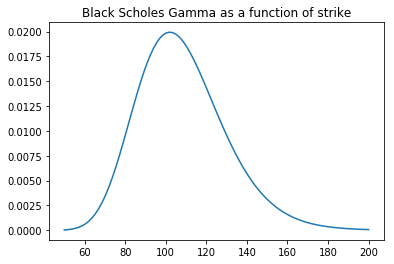

In [3]:
# Simple plot of the Black Scholes Gamma

strikes = np.linspace(50, 200, 100)
plt.plot(strikes, black_scholes_gamma(0.2, 100.0, 1.0, strikes))
plt.title('Black Scholes Gamma as a function of strike')
plt.show()

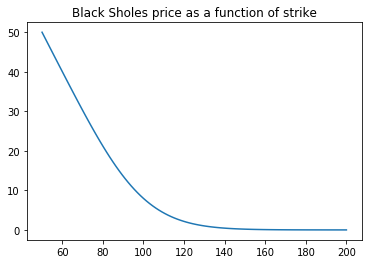

In [4]:
# Simple plot of the Black Scholes price

strikes = np.linspace(50, 200, 100)
plt.plot(strikes, black_scholes_price(0.2, 100.0, 1.0, strikes, True))
plt.title('Black Sholes price as a function of strike')
plt.show()

In [5]:
# Naive implementation of volatility inversion.

from scipy.optimize import brentq

def time_value_vol_inversion(strike, maturity, fwd, time_value):
    """Implied volatility computation for a given time value.
    
    Value of volatility such that:
    
    ``black_scholes_time_value(volatility, maturity, fwd, strike) == time_value``.
    
    - maturity and time_value must be non-negative
    - the returned value is non-negative
    """ 
    if time_value == 0.0:
        return 0.0
    def func(volat):
        return black_scholes_time_value(volat, fwd, maturity, strike) - time_value
    return brentq(func, 0.01, 3.00)

def vol_inversion(strike, maturity, fwd, option_price, IsCall):
    """Implied volatility computation for a given option price.
    
    Value of volatility such that:
    
    ``black_scholes_price(volatility, maturity, fwd, strike, IsCall) == option_price``.
    
    - maturity must be non-negative
    - time value must be non-negative
    - the returned value is non-negative
    """
    if IsCall:
        time_value = option_price - max(fwd - strike, 0.0)
    else:
        time_value = option_price - max(strike - fwd, 0.0)
    return time_value_vol_inversion(strike, maturity, fwd, time_value)

In [6]:
# Simple volatility inversion test.
maturity = 1.0
strike = 100.0
fwd = 100.0
option_price = black_scholes_price(0.3, fwd, maturity, strike, True)
vol_inversion(strike, maturity, fwd, option_price, True)

0.3

** Part II: The particle method and the smile calibration problem **

Let us consider a modified version of the previous model, where we add local volatility term (or leverage function) $l$ in the stock dynamics:

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
d a_t = a_t \gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $\gamma = 50\%$.
- $a_0 = 30\%$.
- $S_0 = 100$.
- $\rho = -50\%$.

The goal is to find a leverage function $l(t, x)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that all the vanilla option prices in the market are such that they match those of a Black-Scholes model, ie. the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 30\%$. In that case, we also have $\sigma_{\textrm{Dup}}(t,x) \equiv 30\%$.

** Implementation **
- Implement the particle method studied in class to set the leverage function $l$. For this purpose, you may use the non-parametric regression routines provided in the previous assignments.
- Using the Monte Carlo method devised in the previous section, check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 30\%$.

** Interpretation **
- While setting $\rho = 0\%$, plot the calibrated leverage function $l(t, S)$ as a function of the spot value for a fixed maturity e.g. $t = T$. Plot the corresponding smile for the pure stochastic volatility model ($l \equiv 1$). By changing the value of the volatility of volatility, comment on the dependence of the shape of the leverage function on the volatility of volatility $\gamma$. Suggested values for $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- For $\gamma = 50\%$, study the joint dependence of the slope of the leverage function and of the smile of the pure stochastic volatility model on the correlation parameter $\rho$.